#Computer Vision Midterm Assignment
## Introduction
Welcome to your Computer Vision midterm project! Here, you'll get hands-on experience building an image recognition model using Convolutional Neural Networks and transfer learning.


##Install Necessary Libraries:

In [27]:
!pip install tensorflow
!pip install keras
!pip install numpy
!pip install matplotlib

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.applications import VGG16, ResNet50, MobileNetV2  # Choose a pre-trained model
from keras.callbacks import ModelCheckpoint

# Additional libraries for data loading (if using a custom dataset)
# from skimage.io import imread  # Example for loading images


**Dataset Selection and Loading**

* **Choose Your Dataset**
   * **Standard Datasets:** CIFAR-10, CIFAR-100, or a suitable subset of ImageNet are good starting points. You can use built-in functions to load them.
   * **Custom Dataset:** If you propose a custom dataset, ensure it has sufficient images per class, good quality, and accurate labeling. You'll need to upload it to Colab.
   * **Select your dataset and uncomment the appropriate loading code.**
   * **If you are using a custom dataset, make sure you have uploaded it to Colab and adjust the file path.**

In [29]:
# select your dataset
from keras.datasets import cifar10 # Or cifar100, or a suitable ImageNet loader

# *** Dataset Loading - Uncomment the lines for your chosen dataset ***

# Option 1: CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Option 2: CIFAR-100
# (x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Option 3: Custom Dataset
# x_train, y_train = load_custom_data('path/to/your/training/data')
# x_test, y_test = load_custom_data('path/to/your/testing/data')

**Markdown Cell: Exploratory Data Analysis (EDA)**

* **Instructions:**
    * Visualize a few random images from your dataset to understand its content and overall quality.
    * Check the shape of your data to confirm the number of images and their dimensions.

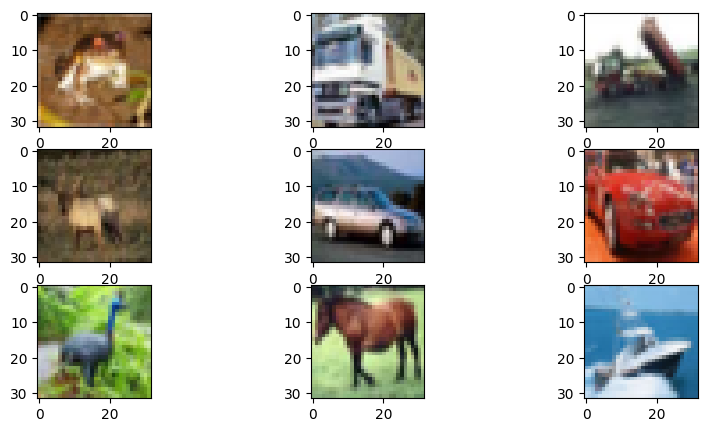

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Class Distribution (Top 10):
[(6, 5000), (9, 5000), (4, 5000), (1, 5000), (2, 5000), (7, 5000), (8, 5000), (3, 5000), (5, 5000), (0, 5000)]


In [30]:
# Insert code here
# Insert code here to display a few sample images from the dataset
## Display sample images
plt.figure(figsize=(10, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i])
plt.show()
#
print('Training data shape:', x_train.shape)
print('Training labels shape:', y_train.shape)
print('Test data shape:', x_test.shape)
print('Test labels shape:', y_test.shape)

# Explore class distribution (if using a standard dataset)
from collections import Counter
print('Class Distribution (Top 10):')
print(Counter(y_train.flatten()).most_common(10))

**Image Preprocessing**

* **Instructions:**
    1. **Normalization:**
       * Normalize pixel values (usually to the range of 0-1 or -1 to 1)  
    2. **Resizing:**
       * Resize images to a consistent size for model input.

In [31]:
# Insert code here to normalize images
# Normalize the data
mean = np.mean(x_train, axis=(0, 1, 2))
std = np.std(x_train, axis=(0, 1, 2))
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# Resize images if needed (adjust input_shape in model building accordingly)
x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))

# Insert code here to resize images, if needed

In [32]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# ** Data Augmentation **

* **Instructions:**

1. Experiment with Parameters:  The code below has some example data augmentation parameters. Try changing the values within these parameters, or even adding new augmentation techniques! Here's a short guide:

* Hint 1: Start with small adjustments to see the effects clearly.
* Hint 2: Consider which augmentations make sense for your dataset. Flipping images of letters might be okay, but rotating them too much could make them unreadable!

* Explore more: Try adding things like shear_range (for shearing transformations) or zoom_range (for random zooming).

2. Visualize the Effects: After setting up your ImageDataGenerator, add a few lines of code to display some randomly augmented images from your dataset. This will help you see how your chosen parameters change the images.
* Hint: Use a small sample of images so it's easy to compare the originals with the augmented versions.

In [33]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)
datagen.fit(x_train) # Fit the augmentation parameters to the training data


#Model Building (Transfer Learning)

In [34]:
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD

# Choose a pre-trained model suitable for object recognition (VGG16, ResNet50, MobileNetV2 are all options)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])

# Freeze some layers of the pre-trained model (optional)
for layer in base_model.layers[:10]:
    layer.trainable = False

# Ensure all remaining layers are trainable (optional fine-tuning step)
for layer in base_model.layers[10:]:
    layer.trainable = True

# Add custom top layers
num_classes = 10

x = base_model.output
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Adjust num_classes for your dataset

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='sgd',  # Example: Replace with SGD optimizer
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Model Training




In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,  # Adjust as needed
                    validation_data=(x_test, y_test),
                    callbacks=[
                        ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
                        reduce_lr,
                        early_stopping
                    ])


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 49ms/step - accuracy: 0.1565 - loss: 2.4607 - val_accuracy: 0.1023 - val_loss: 49.1911 - learning_rate: 0.0100
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.2147 - loss: 2.1597 - val_accuracy: 0.1000 - val_loss: 1870.7708 - learning_rate: 0.0100
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.2483 - loss: 2.0516 - val_accuracy: 0.1000 - val_loss: 782.4876 - learning_rate: 0.0100
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.2730 - loss: 1.9850 - val_accuracy: 0.1261 - val_loss: 2.3948 - learning_rate: 0.0100
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.3067 - loss: 1.9146 - val_accuracy: 0.1019 - val_loss: 2.9980 - learning_rate: 0.0100
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.3345 - loss: 1.8515 - val_accuracy: 0.1000 - val_loss: 4502.5249 - learning_rate: 0.0100
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/ste

#Enhanced Training

Implement data augmentation within the training loop.
Add callbacks to monitor progress and save the best performing model.
Modify the Training Code: If you haven't already, we need to make a few changes to your training loop:

1.   Integrate the Data Augmentation: Replace the
direct use of x_train with datagen.flow(x_train, y_train, batch_size=32). This will apply your augmentations in real-time during training
2.   Use the Validation Set: We already have validation_data=(x_test, y_test).
3. Save the Best Model: We're using a ModelCheckpoint callback to automatically save the model if its performance on the validation set improves
* Hint: Experiment with different batch sizes as well.

In [37]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# Data Augmentation with ImageDataGenerator
datagen = ImageDataGenerator(
       rotation_range=20,
       width_shift_range=0.1,
       height_shift_range=0.1,
       horizontal_flip=True)

#  Modify the model fitting to use real-time augmentation
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(x_test, y_test),  # Use the test set for validation
                    callbacks=[ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')])


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.3957 - loss: 1.6659 - val_accuracy: 0.4433 - val_loss: 1.5496
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.4100 - loss: 1.6348 - val_accuracy: 0.3745 - val_loss: 1.7239
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.4156 - loss: 1.6220 - val_accuracy: 0.4599 - val_loss: 1.7118
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.4307 - loss: 1.5933 - val_accuracy: 0.4702 - val_loss: 1.7213
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.4355 - loss: 1.5712 - val_accuracy: 0.4453 - val_loss: 1.6010
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.4456 - loss: 1.5502 - val_accuracy: 0.4331 - val_loss: 2.2624
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.4566 - loss: 1.5156 - val_accuracy: 0.3485 - val_loss: 8.7863
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.4598 -

#Visualizing Training Progress

Importance of Monitoring: Explain why tracking validation metrics helps identify overfitting or underfitting.

*   Plot training and validation accuracy/loss curves.


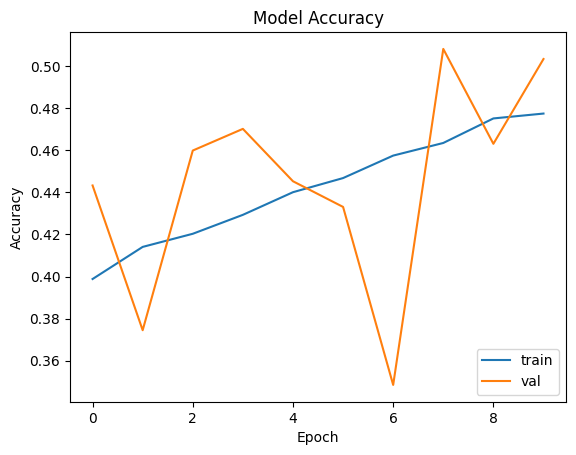

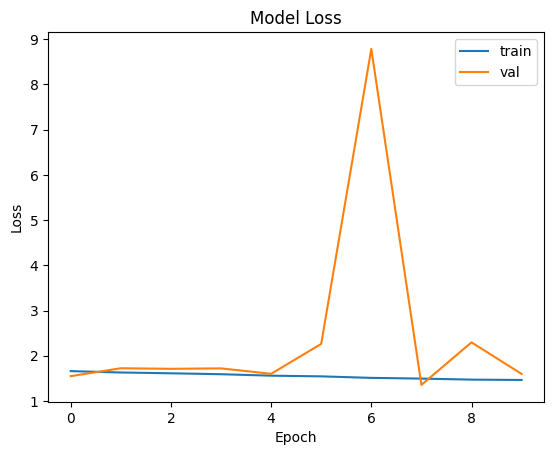

In [38]:
# Plot training and validation curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Plot the loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


#Evaluation on the Test Set

Discuss how test set metrics provide the most unbiased assessment of model performance.

In [39]:
best_model = load_model('best_model.keras')
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5075 - loss: 1.3585
Test Loss: 1.3554160594940186
Test Accuracy: 0.5081999897956848


#Hyperparameter Tuning

>Exploring Learning Rates: In the provided code, we're iterating through different learning rates.
* Hint 1: A good starting range for the learning rate is often between 0.01 and 0.0001.
* Hint 2: Pay close attention to how quickly the validation loss starts to increase (if it does), which might signal a learning rate that's too high.



In [40]:
def create_model(learning_rate=0.01):
    # Load base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Freeze some layers (optional)
    for layer in base_model.layers[:10]:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


#Confusion Matrx

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


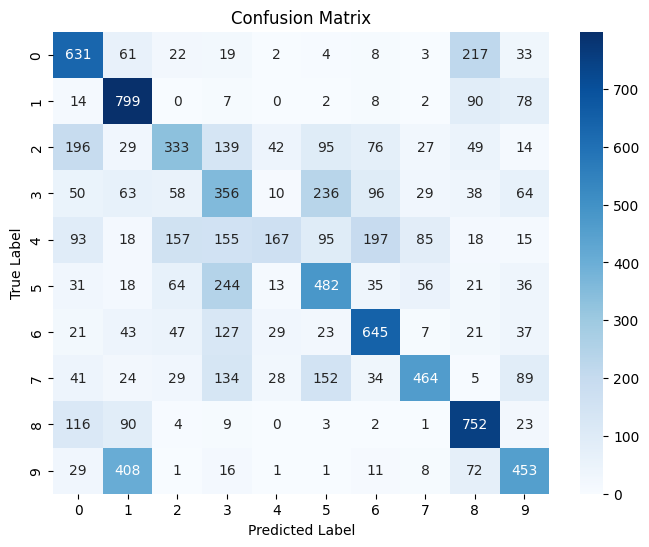

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#Discussion and Further Exploration

##Questions to consider:
1. How does the choice of pre-trained model (VGG16, ResNet50, etc.) affect the results?
*The choice of the pre-trained model affects results significantly. VGG16 is simpler and faster to train, making it suitable for small datasets, while ResNet50 performs better on complex tasks due to its residual connections, but it is computationally heavier. MobileNetV2 is lightweight and ideal for hardware-constrained environments.*
2. Analyze the confusion matrix: Are errors more common between certain classes? What might explain this?
*From the confusion matrix, errors are often more common between visually similar classes, such as cats and dogs, due to feature similarities, class imbalance, or the pretrained features not aligning well with the dataset.*
3. Experiment with different degrees of fine-tuning (freezing more/fewer layers of the pre-trained model).
*Fine-tuning layers impacts performance; freezing fewer layers allows the model to better adapt to the dataset, whereas freezing more layers is effective when the dataset is small or closely resembles the pretrained dataset.*
4. If applicable to your dataset, can you collect more data for classes with higher error rates?
*To improve class accuracy, you can collect more data for classes with higher error rates and apply advanced augmentation strategies like Mixup or CutMix to create diverse training examples.*

5. What are other ways to potentially improve accuracy? (e.g., ensembling models, exploring advanced augmentation strategies, class-weighted training)

*Other ways to improve accuracy include using class weights to handle imbalanced datasets, ensembling predictions from multiple models for robustness, and exploring transfer learning or custom pretraining for better feature adaptation.*

Sources
towardsdatascience.com/build-your-own-deep-learning-classification-model-in-keras-511f647980d6
stackoverflow.com/questions/69997327/tensorflow-valueerror-input-0-is-incompatible-with-layer-model-expected-shape
www.influxdata.com/blog/time-series-forecasting-with-tensorflow-influxdb/